Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Load Dataset

In [2]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
image_size = 224

path = "drive/MyDrive/raw-img/"
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset = "training",
    seed = 111,
    image_size = (image_size, image_size),
    batch_size = 32)

val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset = "validation",
    seed = 111,
    image_size = (image_size, image_size),
    batch_size = 32)

class_names = np.array(train_ds.class_names)
print("Class names:", class_names)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Class names: ['cane' 'cavallo' 'elefante' 'farfalla' 'gallina' 'gatto' 'mucca' 'pecora'
 'ragno' 'scoiattolo']


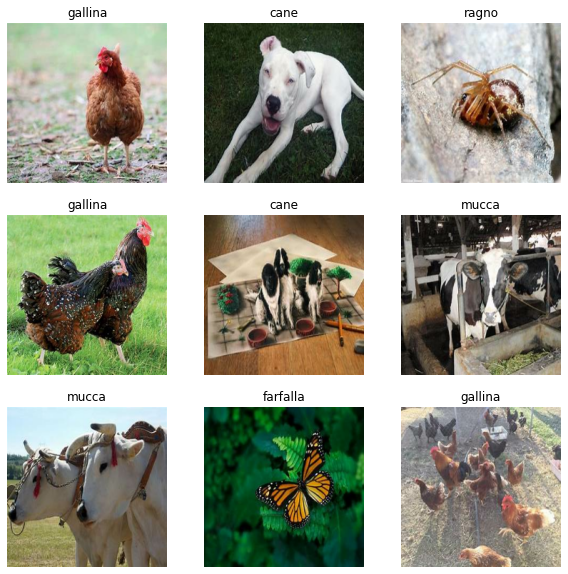

In [4]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Test Set

In [5]:
print("Validation batches before split: %d" % tf.data.experimental.cardinality(val_ds))

# Splits the validation dataset into test dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

Validation batches before split: 164


In [6]:
print("Validation batches after split: %d" % tf.data.experimental.cardinality(val_ds))
print("Test Batches: %d" % tf.data.experimental.cardinality(test_ds))

Validation batches after split: 132
Test Batches: 32


Preprocessing

In [7]:
# Buffered Prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),                                       
  ],
)

EfficientNetB0

In [9]:
# Importing the efficient net
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3),
                                       include_top=False,
                                       weights='imagenet',
                                       pooling='avg')
base_model.trainable = False

In [10]:
# base_model.summary()

In [11]:
# Build the model: Freezes all layers and trains the data on the top layers
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


Compiling the model

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Training Neural Network Model

In [14]:
# Early stop to account for overfitting/underfitting with set epochs
es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=10)

In [15]:
NUM_EPOCH = 2500 # Arbitrarily large for early stop

history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCH, callbacks=[es])

Epoch 1/2500
655/655 [==============================] - 496s 746ms/step - loss: 1.3326 - accuracy: 0.6294 - val_loss: 0.6655 - val_accuracy: 0.9076
Epoch 2/2500
655/655 [==============================] - 50s 76ms/step - loss: 0.6788 - accuracy: 0.8226 - val_loss: 0.3800 - val_accuracy: 0.9411
Epoch 3/2500
655/655 [==============================] - 50s 77ms/step - loss: 0.5335 - accuracy: 0.8506 - val_loss: 0.2813 - val_accuracy: 0.9511
Epoch 4/2500
655/655 [==============================] - 51s 77ms/step - loss: 0.4625 - accuracy: 0.8662 - val_loss: 0.2339 - val_accuracy: 0.9544
Epoch 5/2500
655/655 [==============================] - 51s 78ms/step - loss: 0.4201 - accuracy: 0.8740 - val_loss: 0.2053 - val_accuracy: 0.9563
Epoch 6/2500
655/655 [==============================] - 51s 78ms/step - loss: 0.4009 - accuracy: 0.8764 - val_loss: 0.1875 - val_accuracy: 0.9582
Epoch 7/2500
655/655 [==============================] - 51s 78ms/step - loss: 0.3823 - accuracy: 0.8799 - val_loss: 0.1745

Evaluation

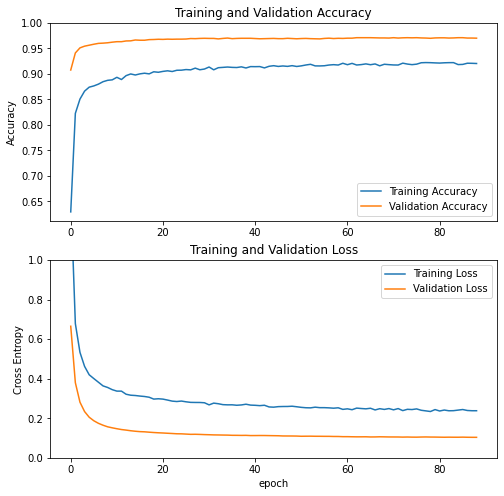

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Prediction

In [17]:
# Loss and accuracy score
test_score = model.evaluate(test_ds)
print('Test loss :', test_score[0])
print('Test accuracy :', test_score[1])

val_score = model.evaluate(val_ds)
print('Validation loss :', val_score[0])
print('Validation accuracy :', val_score[1])

32/32 [==============================] - 2s 67ms/step - loss: 0.1068 - accuracy: 0.9697
Test loss : 0.10676167160272598
Test accuracy : 0.9697265625
132/132 [==============================] - 8s 60ms/step - loss: 0.1036 - accuracy: 0.9701
Validation loss : 0.10355556011199951
Validation accuracy : 0.9700783491134644


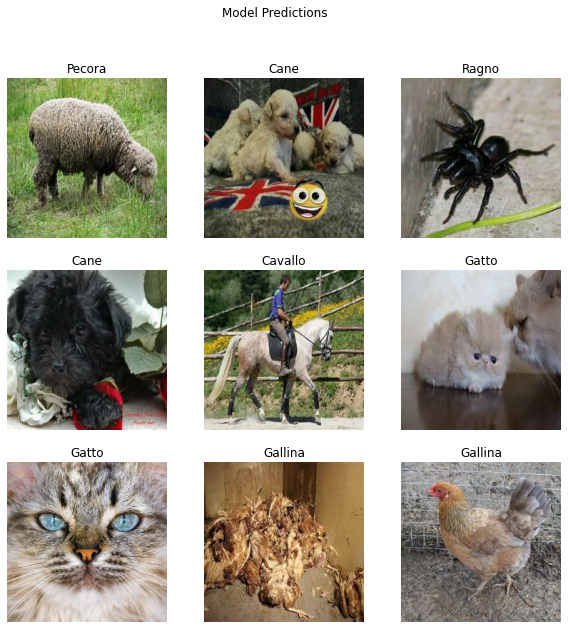

In [18]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict(image_batch)

# Apply a sigmoid since our model returns logits
prediction_id = tf.math.argmax(predictions, axis=-1)
predicted_label_batch = class_names[prediction_id]

# print('Predictions:\n', predictions)
# print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(predicted_label_batch[i].title())
  plt.axis("off")
_= plt.suptitle("Model Predictions")

In [19]:
# __________________________Previous work ________________________________

# animal_translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", 
#              "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
#              "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", 
#              "dog": "cane", "cavallo": "horse", "elephant" : "elefante", 
#              "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", 
#              "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

# animals = ["squirrel", "spider", "sheep", "cow", "cat", 
#            "chicken", "butterfly", "elephant", "horse", "dog"]

# animal_category = ["scoiattolo", "ragno", "pecora", "mucca", "gatto", 
#                    "gallina", "farfalla", "elefante", "cavallo", "cane"]

# animal_dataset = []
# image_size = 244

# categories_loaded = 0
# for animal, translated_animal in animal_translate.items():
#   path = "drive/MyDrive/raw-img/" + animal
#   animal_class = animals.index(translated_animal)
#   # images_loaded = 0
#   for filename in os.listdir(path):
#     # image = Image.open(path + "/" + filename)
#     # grayscale_image = image.convert(mode="L")   # Converts image to grayscale
#     # resized_image = grayscale_image.resize((224,224))   # Resize image to 224x224
#     # animal_dataset.append(resized_image)

#     # image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
#     # resized_image = cv2.resize(image, (image_size, image_size))
#     # animal_dataset.append([resized_image, animal_class])

#     # images_loaded += 1
#     # print(images_loaded)
#   categories_loaded += 1
#   print(categories_loaded)

# dataset = np.array(animal_dataset)
# display(dataset[0])

# random.shuffle(dataset)  # Shuffles the dataset

# # 5 train : 3 valid : 2 test
# X_train, X_valid, X_test = dataset[:13000], dataset[13001:20800], dataset[20801:]
# y_train, y_valid, y_test = dataset[:13000], dataset[13001:20800], dataset[20801:]

# print(X_train.shape)
# print(X_valid.shape)
# print(X_test.shape)